In [1]:
# code here copied from the Udacity course material

import numpy as np
import cv2
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

from mpl_toolkits.mplot3d import Axes3D
from functools import partial


# Import everything needed to edit/save/watch video clips
from moviepy.editor import ImageSequenceClip, VideoFileClip
from IPython.display import HTML

import glob
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import matplotlib.image as mpimg

from scipy.ndimage.measurements import label
from skimage.measure import regionprops

import pickle

%matplotlib inline

In [73]:
class Utils:
    @staticmethod
    def read_in_rgb(img_name):
        return cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
    

    @staticmethod
    def plot_all(images, titles, cmaps, x_cnt=3, y_cnt=4, figsize=(25, 10)):
        fig = plt.figure(figsize=(25, 10))
        counter = 1
        for data in zip(images, titles, cmaps):
            fig.add_subplot(x_cnt, y_cnt, counter)
            counter += 1
            if data[2] is None:
                plt.imshow(data[0]) # plot original image  
            else:
                plt.imshow(data[0], cmap=data[2])
            plt.title(data[1])
            
    @staticmethod
    def display_side_by_side(left_img, left_title, right_img, right_title, figsize=(20,10) , left_cmap=None, right_cmap=None):
        fig, axes = plt.subplots(ncols=2, figsize=figsize)
        if left_cmap is None:
            axes[0].imshow(left_img)
        else:
            axes[0].imshow(left_img, cmap=left_cmap)
        axes[0].set_title(left_title)
        """
        for x in src:
            axes[0].plot(x[0], x[1], 'ro')
        for x in dst:
            axes[0].plot(x[0], x[1], 'ro')
        """
        if right_cmap is None:
            axes[1].imshow(right_img)
        else:
            axes[1].imshow(right_img, cmap=right_cmap)
        axes[1].set_title(right_title)
        
    @staticmethod
    def draw_labeled_bboxes(img, labels, scale):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            # cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            p0l,p0r = bbox[0]
            p1l,p1r = bbox[1]
            x_len = abs(bbox[0][1] - bbox[1][1])
            y_len = abs(bbox[0][0] - bbox[1][0])
            x_by_y = x_len / y_len
            y_by_x = y_len / x_len
            if x_by_y > 50 or y_by_x > 50:
                continue
            p0l = np.int(p0l * scale)
            p0r = np.int(p0r * scale)
            p1l = np.int(p1l * scale)
            p1r = np.int(p1r * scale)
            cv2.rectangle(img, (p0l, p0r), (p1l, p1r), (0,0,255), 3)
        # Return the image
        return img    

In [3]:
# Read vehicle and non-vehicle dataset

# vehicle_dataset = list(map(lambda image_filename: (image_filename, Utils.read_in_rgb(image_filename)), 
#                               glob.glob('../../data/P5/vehicles/*/*.png')))
# nonvehicle_dataset = list(map(lambda image_filename: (image_filename, Utils.read_in_rgb(image_filename)), 
#                               glob.glob('../../data/P5/non-vehicles/*/*.png')))

vehicle_dataset = glob.glob('../../data/P5/vehicles/*/*.png')
nonvehicle_dataset = glob.glob('../../data/P5/non-vehicles/*/*.png')

../../data/P5/vehicles\GTI_Far\image0000.png


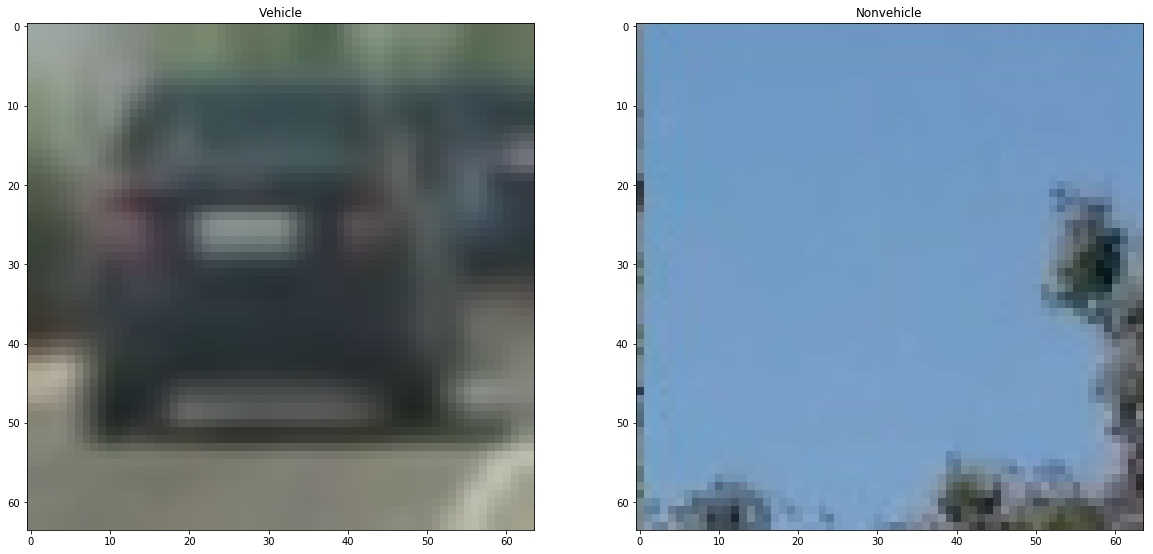

In [11]:
print(vehicle_dataset[0])
Utils.display_side_by_side(mpimg.imread(vehicle_dataset[0]), "Vehicle",
                           mpimg.imread(nonvehicle_dataset[0]), "Nonvehicle")

In [5]:
# from udacity course material

class HoG:
    # Define a function to return HOG features and visualization
    @staticmethod
    def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                           visualise=vis, feature_vector=feature_vec)
            return features


In [12]:
class FeatureExtractionUtils:
    # Define a function to compute binned color features  
    @staticmethod
    def bin_spatial(img, size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features

    @staticmethod
    def color_hist(img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the RGB channels separately
        rhist = np.histogram(img[:,:,0], nbins, bins_range)
        ghist = np.histogram(img[:,:,1], nbins, bins_range)
        bhist = np.histogram(img[:,:,2], nbins, bins_range)
        # Generating bin centers
        bin_edges = rhist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features, rhist, ghist, bhist, bin_centers
    
    @staticmethod
    def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for file in imgs:
            feature_image = mpimg.imread(file)
            features.append(np.concatenate(FeatureExtractionUtils.extract_features_single(feature_image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)))
        return features
    
    
    @staticmethod
    def extract_features_single(feature_image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
        # Create a list to append feature vectors to
        features = []
        file_features = []
        # Iterate through the list of images
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = cv2.cvtColor(feature_image, eval('cv2.COLOR_RGB2{}'.format(color_space)))  

        if spatial_feat == True:
            spatial_features = FeatureExtractionUtils.bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features, _, _, _, _ = FeatureExtractionUtils.color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(HoG.get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = HoG.get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        # Return list of feature vectors
        return features  

In [14]:
# extract features
color_space = 'YCrCb' #HSV:99 # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


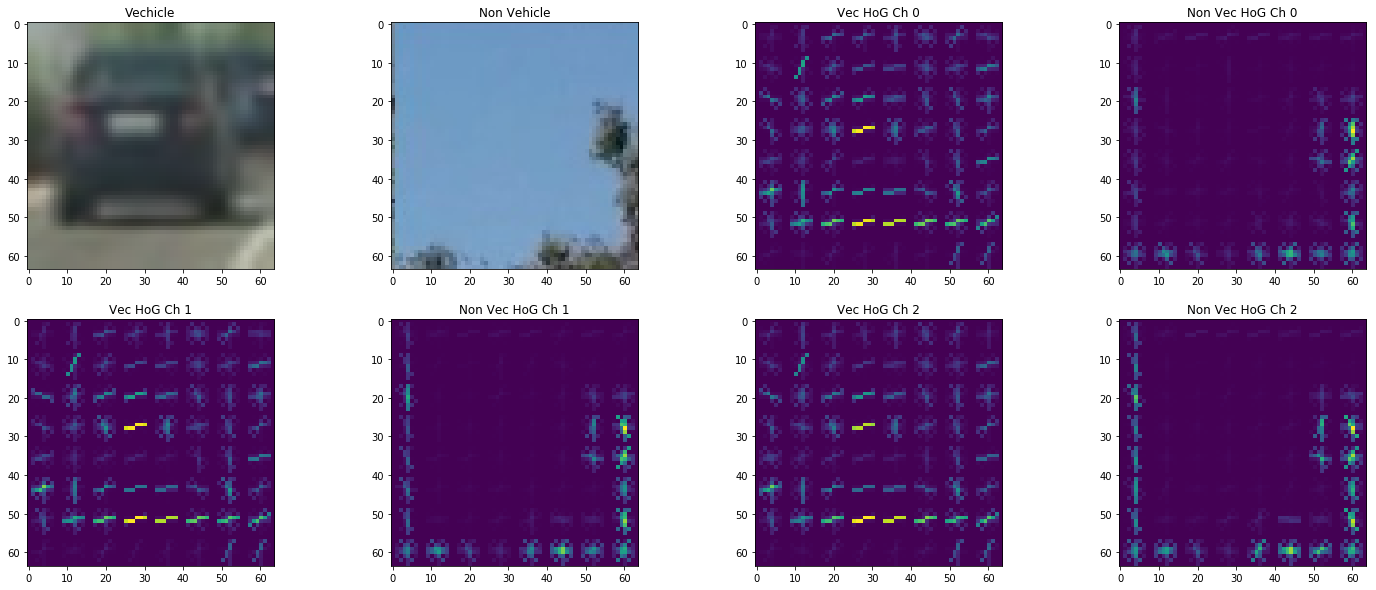

In [74]:
vec_file = vehicle_dataset[0]
non_vec_file = nonvehicle_dataset[0]

vec = mpimg.imread(vec_file)
non_vec = mpimg.imread(non_vec_file)


images = []
titles = []
cmaps = []
images.append(vec)
titles.append("Vechicle")
cmaps.append(None)
images.append(non_vec)
titles.append("Non Vehicle")
cmaps.append(None)

for i in range(0,3):
    vec_hog_1, vec_hog_img_1 = HoG.get_hog_features(vec[:,:,i], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=True, feature_vec=True)
    images.append(vec_hog_img_1)
    titles.append("Vec HoG Ch {}".format(i))
    cmaps.append(None)
    non_vec_hog_1, non_vec_hog_img_1 = HoG.get_hog_features(non_vec[:,:,i], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=True, feature_vec=True)
    images.append(non_vec_hog_img_1)
    titles.append("Non Vec HoG Ch {}".format(i))
    cmaps.append(None)

Utils.plot_all(images, titles, cmaps, 2, 4)


In [64]:

t = time.time()
# read vehicles
vehicle_features = FeatureExtractionUtils.extract_features(vehicle_dataset, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
# read non-vehicles
nonvehicle_fatures = FeatureExtractionUtils.extract_features(nonvehicle_dataset, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

87.76 Seconds to extract HOG features...


In [12]:
print('Number of Samples for each class: ', len(vehicle_features), len(nonvehicle_fatures))
print('Number of Features for each class: ', vehicle_features[0].shape, nonvehicle_fatures[0].shape)

Number of Samples for each class:  8792 8968
Number of Features for each class:  (8460,) (8460,)


# TRAIN CLASSIFIER

In [13]:
# Create an array stack of feature vectors
X = np.vstack((vehicle_features, nonvehicle_fatures)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(nonvehicle_fatures))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
yt2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
18.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9887
My SVC predicts:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
0.03008 Seconds to predict 10 labels with SVC
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
9.04 Seconds to train SVC...
Test Accuracy of SVC =  0.9887
My SVC predicts:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
-0.09528 Seconds to predict 10 labels with SVC


In [14]:
print('Train Accuracy: ', svc.score(X_train, y_train), 'Test Accuracy: ', svc.score(X_test, y_test))
from sklearn.metrics import confusion_matrix
y_pred = svc.predict(X_test)
confusion_matrix(y_test, y_pred)

Train Accuracy:  1.0 Test Accuracy:  0.988738738739


array([[1795,   16],
       [  24, 1717]], dtype=int64)

In [40]:
# pickle.dump(svc, open("svc.p", "wb"))
# pickle.dump(X_scaler, open("scaler.p", "wb"))
svc = pickle.load(open("svc.p", "rb"))
X_scaler = pickle.load(open("scaler.p", "rb"))

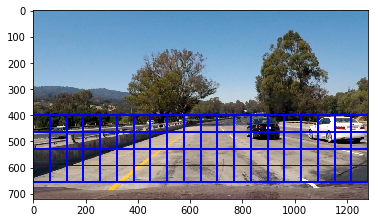

In [41]:
class SlidingWindows:
    # Here is your draw_boxes function from the previous exercise
    @staticmethod
    def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
        # Make a copy of the image
        imcopy = np.copy(img)
        # Iterate through the bounding boxes
        for bbox in bboxes:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        # Return the image copy with boxes drawn
        return imcopy


    # Define a function that takes an image,
    # start and stop positions in both x and y, 
    # window size (x and y dimensions),  
    # and overlap fraction (for both x and y)
    @staticmethod
    def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
        x_start_stop_x = x_start_stop[0]
        x_start_stop_y = x_start_stop[1]
        y_start_stop_x = y_start_stop[0]
        y_start_stop_y = y_start_stop[1]
        if x_start_stop_x == None:
            x_start_stop_x = 0
        if x_start_stop_y == None:
            x_start_stop_y = img.shape[1]
        if y_start_stop_x == None:
            y_start_stop_x = 0
        if y_start_stop_y == None:
            y_start_stop_y = img.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop_y - x_start_stop_x
        yspan = y_start_stop_y - y_start_stop_x   
        x_start_stop = (x_start_stop_x, x_start_stop_y)
        y_start_stop = (y_start_stop_x, y_start_stop_y)
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))    
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        window_list = []
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Loop through finding x and y window positions
        #     Note: you could vectorize this step, but in practice
        #     you'll be considering windows one by one with your
        #     classifier, so looping makes sense
            # Calculate each window position
            # Append window position to list
        # Return the list of windows
        return window_list
    
    @staticmethod
    def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

        #1) Create an empty list to receive positive detection windows
        on_windows = []
        #2) Iterate over all windows in the list
        for window in windows:
            #3) Extract the test window from original image
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
            #4) Extract features for that window using single_img_features()
            features = FeatureExtractionUtils.extract_features_single(test_img, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            #5) Scale extracted features to be fed to classifier
            test_features = scaler.transform(np.array(features).reshape(1, -1))
            #6) Predict using your classifier
            prediction = clf.predict(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
        #8) Return windows for positive detections
        return on_windows

img_filename = "./test_images/test1.jpg"
image = mpimg.imread(img_filename)
draw_image = np.copy(image)
windows = SlidingWindows.slide_window(image, x_start_stop=(0, None), y_start_stop=(400, 700), 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))

window_img = SlidingWindows.draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)



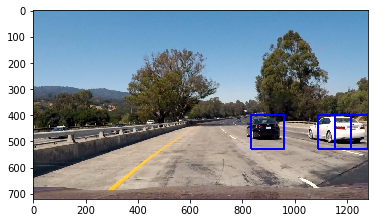

In [42]:
windows = SlidingWindows.slide_window(image, x_start_stop=(0, None), y_start_stop=(400, 700), 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))
norm_img = image.astype(np.float32)/255
hot_windows = SlidingWindows.search_windows(norm_img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = SlidingWindows.draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [43]:
def add_heat(heat, boxlist):
    # Iterate through list of bboxes
    for box in boxlist:
        # Add += 1 for all pixels inside each bbox
        x_len = abs(box[0][1] - box[1][1])
        y_len = abs(box[0][0] - box[1][0])
        x_by_y = x_len / y_len
        y_by_x = y_len / x_len
        if x_by_y > 50 or y_by_x > 50:
            continue
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heat
    
def apply_threshold(heatmap, threshold):
    heatMap = np.copy(heatmap)
    # Zero out pixels below the threshold
    heatMap[heatMap < threshold] = 0
    # Return thresholded map
    return heatMap

def process_img(image):
    y_start_stop = [np.int(image.shape[0]/2)+20, image.shape[0]-30] 
    draw_image = np.copy(image)
    
    windows1 = SlidingWindows.slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    
    windows2 = SlidingWindows.slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(95, 95), xy_overlap=(0.5, 0.5))
    
    windows3 = SlidingWindows.slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(58, 58), xy_overlap=(0.5, 0.5))
    
    windows = windows1 + windows2 + windows3

    hot_windows = SlidingWindows.search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = SlidingWindows.draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)  
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, hot_windows)    
    
    heatmapThr = apply_threshold(heatmap, 2)
    final_map = np.clip(heatmapThr - 2, 0, 255)
    
    return window_img, heatmap, heatmapThr, final_map

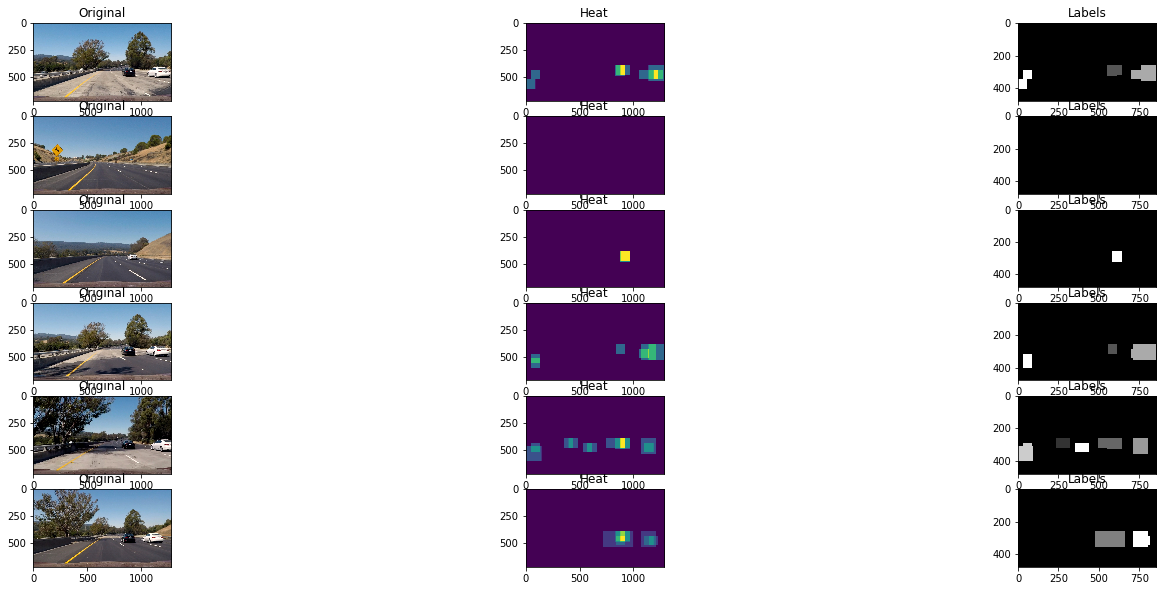

In [75]:
import glob
import numpy as np
import matplotlib.pyplot as plt

directory = './test_images/*.jpg'
glob_dir = glob.glob(directory)
fig = plt.figure(figsize=(25, 10))
counter = 1
scale = 1.5

images_to_plot = []
titles_to_show = []
cmaps = []
for filename in glob_dir:
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, eval('cv2.COLOR_BGR2{}'.format('RGB')))  
    # imgProcess = cv2.cvtColor(img, eval('cv2.COLOR_RGB2{}'.format(color_space))) 
    
    imgProcess = img.astype(np.float32)/255
    
    if scale !=1:
        imgProcess = cv2.resize(imgProcess, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale) ) )
    
    window_img = process_img(imgProcess)

    images_to_plot.append(img)
    titles_to_show.append('Original')
    cmaps.append(None)
    
    output_res = cv2.resize(window_img[1], (img.shape[1], img.shape[0]))
    images_to_plot.append(output_res)
    titles_to_show.append("Heat")
    cmaps.append(None)
    
    labels = label(window_img[1])
    images_to_plot.append(labels[0])
    titles_to_show.append("Labels")
    cmaps.append("gray")
    
Utils.plot_all(images_to_plot, titles_to_show, cmaps, 6, 3)

    

In [38]:
class VehicleTracker():
    def __init__(self):
        self.curr_heatmap = None
        self.avg_heatmap = None
        self.thr_heatmap = None
        
    def add_heatmap(self, heatmap):
        self.curr_heatmap = apply_threshold(heatmap, 1)
        if self.avg_heatmap is None:
            self.avg_heatmap = self.curr_heatmap
        else:
            self.avg_heatmap = (0.75 * self.avg_heatmap + 0.75 * self.curr_heatmap) 
        self.thr_heatmap = apply_threshold(self.avg_heatmap, 2)
        
    @property
    def heatmap(self):
        return self.thr_heatmap

In [39]:
vehicle_tracker = VehicleTracker()
def videoProcess(img):    
    scale = 1.5

    draw_image = np.copy(img)
    image = img.astype(np.float32)/255.
    
    if scale != 1:
        image = cv2.resize(image, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale) ) )
    
    y_start_stop = [np.int(image.shape[0]/2)+20, image.shape[0]-30] 
    
    
    windows1 = SlidingWindows.slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    
    windows2 = SlidingWindows.slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(95, 95), xy_overlap=(0.5, 0.5))
    
    windows3 = SlidingWindows.slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(58, 58), xy_overlap=(0.5, 0.5))
    
    # print(windows1, windows2, (windows1+windows2))
    windows = windows1 + windows2 + windows3

    hot_windows = SlidingWindows.search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = SlidingWindows.draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)  
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, hot_windows)
    
    vehicle_tracker.add_heatmap(heatmap)
    heatmap = vehicle_tracker.heatmap
        
    labels = label(heatmap)
    imageOut = Utils.draw_labeled_bboxes(np.copy(img), labels, scale)
    return imageOut

In [40]:

# process videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# initiate instance
#vehicleTrackerIns = vehicleTracker()

# video processing
# input_name = 'project_video'
input_name = 'test_video'
output = input_name + "_out.mp4"
clip = VideoFileClip(input_name + ".mp4")#.subclip(45,49)
clip = clip.fl_image(videoProcess)
clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:48<00:01,  1.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

